In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
import cv2
import glob

In [3]:
labels_df=pd.read_csv('D:/datasets/haemorrhage/labels.csv')
labels=np.array(labels_df[' hemorrhage'].tolist())
files=sorted(glob.glob('D:/datasets/haemorrhage/head_ct/*.png'))
images=np.array([cv2.imread(path) for path in files])

In [4]:
images_df=pd.DataFrame(images,columns=['image'])
images_df['width']=images_df['image'].apply(lambda x:x.shape[0])
images_df['height']=images_df['image'].apply(lambda x:x.shape[1])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C8F69A898>,
      dtype=object)

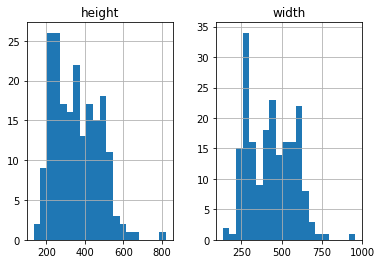

In [5]:
images_df[['height','width']].hist(bins=20)

In [6]:
images_df[['height','width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


In [7]:
images=np.array([cv2.resize(image,(128,128)) for image in images])

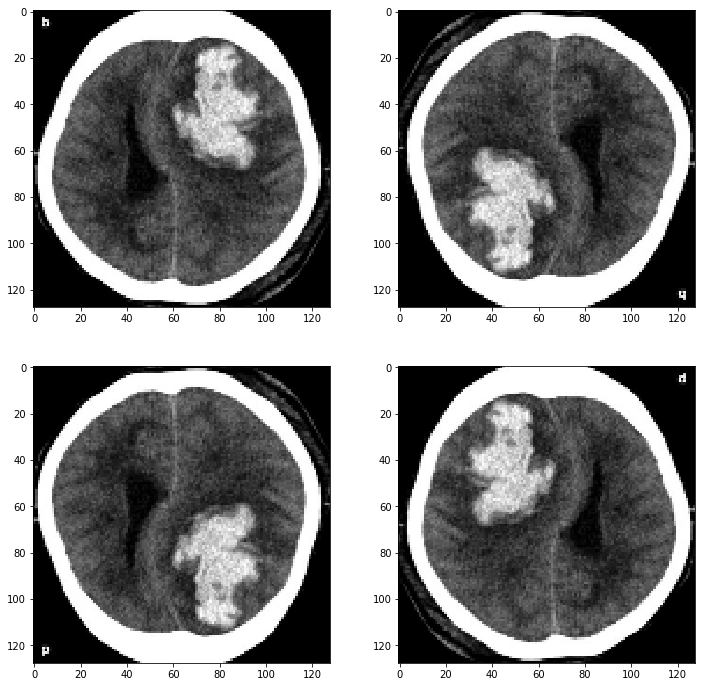

In [8]:
plt.figure(figsize=(12,12))
for i,flip in enumerate([None,-1,0,1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
         plt.imshow(cv2.flip(images[0],flip))   

In [9]:
indicies=np.random.permutation(100)
train_true_idx,test_true_idx=indicies[:90],indicies[90:]
train_false_idx,test_false_idx=indicies[:90]+100,indicies[90:]+100
train_idx,test_idx=np.append(train_true_idx,train_false_idx),np.append(test_true_idx,test_false_idx)
train_validationX,train_validationY=images[train_idx],labels[train_idx]
testX,testY=images[test_idx],labels[test_idx]
print(train_validationX.shape,testX.shape)
print(train_validationY.shape,testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [10]:
tr_len=train_validationX.shape[0]
train_val_split=int(tr_len*0.9)
indicies=np.random.permutation(tr_len)
train_idx,validation_idx=indicies[:train_val_split],indicies[train_val_split:]
trainX,trainY=train_validationX[train_idx],train_validationY[train_idx]
validationX,validationY=train_validationX[validation_idx],train_validationY[validation_idx]
print(trainX.shape,validationX.shape)
print(trainY.shape,validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


In [11]:
import keras

Using TensorFlow backend.


In [14]:
from keras.models import Sequential
from keras.layers import Dense,Input,Flatten,Dropout,Conv2D,MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

In [15]:
train_image_data=ImageDataGenerator(rescale=1./255,shear_range=0.,zoom_range=0.05,rotation_range=180,width_shift_range=0.05,height_shift_range=0.05,horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0)
validation_image_data=ImageDataGenerator(rescale=1./255,shear_range=0.,zoom_range=0.05,rotation_range=90,width_shift_range=0.05,height_shift_range=0.05,horizontal_flip=True,vertical_flip=True,fill_mode='constant',cval=0)

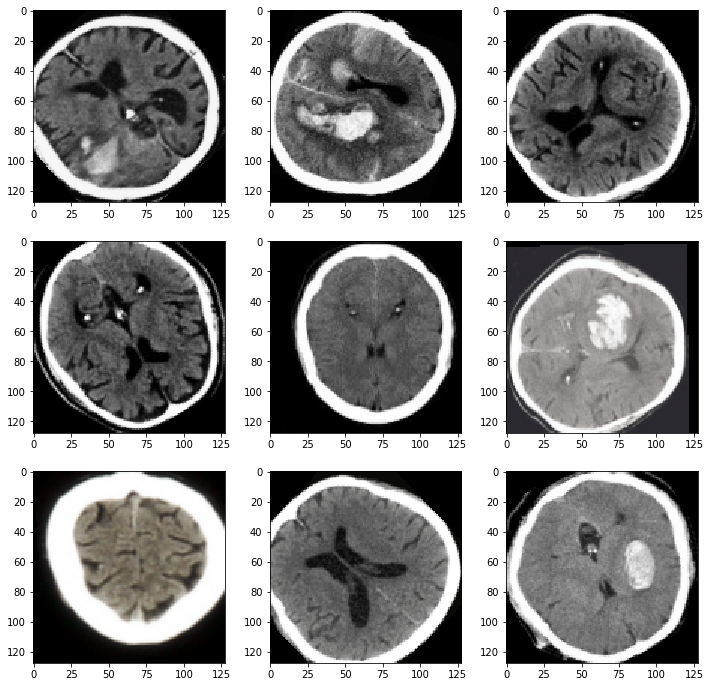

In [16]:
plt.figure(figsize=(12,12))
for X_batch,y_batch in train_image_data.flow(trainX,trainY,batch_size=9):
    for i in range(0,9):
        plt.subplot(330 +1+i)
        plt.imshow(X_batch[i])
    plt.show()
    break

In [27]:
#building model
def check_accuracy(model,setX,actual,print_images=True):
    predicted=np.array([int(x[0]>0.5) for x in model.predict(setX)])
    if print_images:
        rows=math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20,3*rows))
        for i in range(len(predicted)):
            plt.subplot(rows,10,i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+"actual "+str(actual[i]))
    confusion=confusion_matrix(actual,predicted)
    tn,fp,fn,tp=confusion.ravel()
    print("True positive:",fp,",False negative:",fn)
    print("Total accuracy:",np.sum(predicted==actual)/len(predicted)*100.,"%")
    return (tn,fp,fn,tp)

In [23]:
def bigger_conv_model(input_shape):
    model=Sequential()
    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same',activation='relu',input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32,kernel_size=3,strides=2,padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same',activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1,activation='sigmoid'))
    return model

In [22]:
def imbalance_set(coeff=2):
    imbalanced_trainX=[]
    imbalanced_trainY=[]
    for i,train_x in enumerate(trainX):
        def add_entry(x,y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)
            
        add_entry(train_x,trainY[i])
        
        if(trainY[i]==1):
            for j in range(coeff-1):
                add_entry(train_x,trainY[i])
    return(np.array(imbalanced_trainX),np.array(imbalanced_trainY))
imbalanced_trainX,imbalanced_trainY=imbalance_set(2)
print(imbalanced_trainX.shape,imbalanced_trainY.shape)

(249, 128, 128, 3) (249,)


In [24]:
model=bigger_conv_model((128,128,3))
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
global_average_poolin

In [25]:
model.fit_generator(train_image_data.flow(imbalanced_trainX,imbalanced_trainY,batch_size=128),steps_per_epoch=128,validation_data=validation_image_data.flow(validationX,validationY,batch_size=16),validation_steps=100,callbacks=[ModelCheckpoint("bigger_model_chcekpoint_weights.h5",monitor='val_acc',save_best_only=True,mode='max')],epochs=24)

Instructions for updating:
Use tf.cast instead.
Epoch 1/24
128/128 [==============================] - 73s 569ms/step - loss: 0.5904 - acc: 0.6998 - val_loss: 0.8507 - val_acc: 0.2222
Epoch 2/24
128/128 [==============================] - 63s 493ms/step - loss: 0.5458 - acc: 0.7283 - val_loss: 1.4016 - val_acc: 0.2222
Epoch 3/24
128/128 [==============================] - 64s 498ms/step - loss: 0.5211 - acc: 0.7516 - val_loss: 0.4574 - val_acc: 0.8211
Epoch 4/24
128/128 [==============================] - 64s 504ms/step - loss: 0.4981 - acc: 0.7646 - val_loss: 0.5444 - val_acc: 0.7211
Epoch 5/24
128/128 [==============================] - 63s 496ms/step - loss: 0.4819 - acc: 0.7780 - val_loss: 0.4801 - val_acc: 0.7500
Epoch 6/24
128/128 [==============================] - 64s 497ms/step - loss: 0.4539 - acc: 0.7889 - val_loss: 0.3090 - val_acc: 0.9200
Epoch 7/24
128/128 [==============================] - 64s 497ms/step - loss: 0.4345 - acc: 0.8022 - val_loss: 0.4968 - val_acc: 0.7389
Epoch 8

In [28]:
check_accuracy(model,trainX/255.,trainY,False)

True positive: 10 ,False negative: 0
Total accuracy: 93.82716049382715 %


(65, 10, 0, 87)

In [29]:
check_accuracy(model,validationX/255.,validationY,False)

True positive: 1 ,False negative: 0
Total accuracy: 94.44444444444444 %


(14, 1, 0, 3)

In [31]:
model.save("bigger_model_latest_weights.h5")
#model.load_weights("bigger_model_checkpoint_weights.h5")

In [33]:
model.load_weights("bigger_model_chcekpoint_weights.h5")
check_accuracy(model,trainX/255.,trainY,False)

True positive: 10 ,False negative: 5
Total accuracy: 90.74074074074075 %


(65, 10, 5, 82)